# Some analysis on my ~7500 Reddit comments


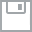
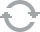
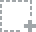
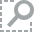
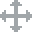
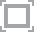
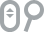
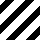
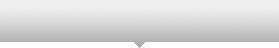
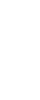
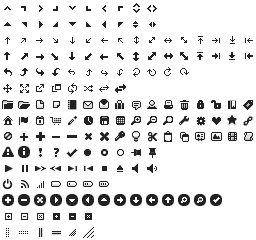
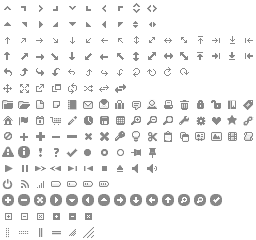
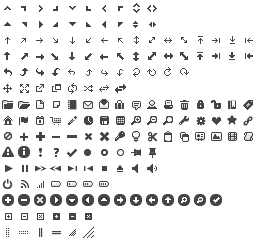
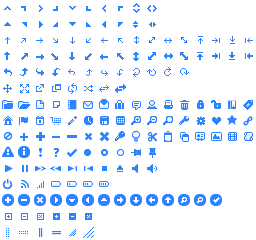
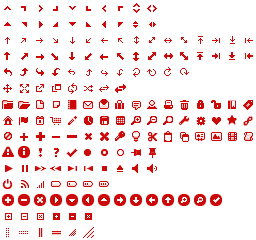
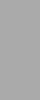
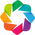
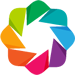

In [109]:
%matplotlib inline
import json
import pandas as pd
import datetime
from bokeh.plotting import figure, output_notebook, show
from bokeh.charts import Bar
from bokeh.models.grids import Grid
from bokeh.models.axes import LinearAxis, CategoricalAxis
from bokeh.models.ranges import FactorRange
from bokeh.models.renderers import GlyphRenderer
from bokeh.models.glyphs import Text
from bokeh.palettes import Blues9
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
output_notebook()

# Define a helper function for pretty printing out Python output
def printmd(string):
    display(Markdown(string))

Firstly, we want to define a function that will grab all of our comment data and convert it to dictionaries from JSON.

In [14]:
def parse_comment_file():
    """
    Parse each comment in the JSON file into a dict and then add it to a list, then return the list
    """
    # Empty list for storage
    comment_list = []

    # Open the file
    with open('nikskoCommentsToMarch2016.json', 'r') as file:
        # For every line
        for line in file:
            # Parse the line into a dict
            comment_dict = json.loads(line)
            # Put the dict on the end of the list
            comment_list.append(comment_dict)

    return comment_list

Now we can do some analysis. First we'll clean up the data a little.

In [15]:
# Parse the file
comment_list = parse_comment_file()

# Sort the list based on the UTC time
comment_list.sort(key=lambda x: x['created_utc'])

# Throw this into a pandas dataframe
comment_frame = pd.DataFrame(comment_list)

# Fix the datatypes on the columns
comment_frame[['created_utc', 'score']] = comment_frame[['created_utc', 'score']].astype(int)
comment_frame[['subreddit', 'body']] = comment_frame[['subreddit', 'body']].astype(str)

# Convert from unix UTC dates to local times
comment_frame['created_local'] = pd.to_datetime(comment_frame['created_utc'], unit='s')

# Set the created_local as the index
comment_frame = comment_frame.set_index('created_local')

Next, some basic stats.

In [112]:
printmd("Total number of comments:")
print(len(comment_frame))
printmd("First comment:")
print(comment_frame.iloc[0].body)
printmd("Most recent comment:")
print(comment_frame.iloc[-1].body)
printmd("Total comment karma:")
print(comment_frame[['score']].sum()[0])

Total number of comments:

7649


First comment:

From playing hours and hours of Flight Sim, this doesn't look too complicated. Just my opinion though. Impressive wizardry with there with the whole 3d view thing.


Most recent comment:

Linux for Workgroups


Total comment karma:

30665


Next, we'll look at comment frequency. Before we do any plotting, let's make the figures look a little nicer

In [16]:
# Resample daily and count
daily_frame = comment_frame.resample('D', how='count')
# Reset the index for plotting
daily_frame.reset_index(inplace=True)
# Remove and rename some columns
daily_frame = daily_frame.drop(['score', 'created_utc','subreddit'], 1)
daily_frame.columns = ['date', 'count']
daily_frame['rolling_mean'] = pd.rolling_mean(daily_frame['count'], 30, 0)

# Create the figure
p = figure(width=950, height=400, x_axis_type="datetime")
# Plot the data
p.line(daily_frame['date'], daily_frame['count'], color='lightgrey', alpha=0.5)
p.line(daily_frame['date'], daily_frame['rolling_mean'], color='blue')
# Lots of formatting
p.xgrid.grid_line_color = None
p.xgrid[0].ticker.desired_num_ticks = 8
p.xaxis.major_tick_line_alpha = 0
p.xaxis.axis_line_alpha = 0
p.xaxis.major_label_text_alpha = 0.7

p.ygrid.grid_line_dash = [2, 2]
p.ygrid.grid_line_alpha = 0.5
p.ygrid[0].ticker.num_minor_ticks = 0
p.yaxis.major_tick_line_alpha = 0
p.yaxis.axis_line_alpha = 0
p.yaxis.major_label_text_alpha = 0.7

p.outline_line_alpha = 0
p.title = 'Daily comment frequency 2008-2016'
p.title_text_alpha = 0.9
show(p)

The grey line above is the individual comment counts per day, and the blue line is a 30 day moving average.
A brief list of the large humps and their associated causes:
* late 2010: Got really into Minecraft.
* late 2011: Buildup to the release of my first Android device, the Galaxy Nexus
* early 2013: Got really into cameras
* late 2013: Honours happened
* early 2014: Got into 3D printing
* mid 2015: Job got boring, lots of redditing.

Some stats on this daily breakdown:

In [113]:
printmd("Average daily comments:")
print(daily_frame['count'].mean())
printmd("Most comments in one day:")
max_comments_idx = daily_frame['count'].idxmax()
print(str(daily_frame['date'][max_comments_idx].date()) + ", " + str(daily_frame['count'][max_comments_idx]))
printmd("Longest periods between comments:")
current_start_date = daily_frame['date'][0]
current_length = 0
no_comments = []
# Iterate over the frame, counting consecutive days of zero comments and putting the lengths and start
# dates into a pandas array
for index, num_comments in daily_frame['count'].iteritems():
    if num_comments == 0:
        current_length += 1
    else:
        # Add the date, length pair as a date, timedelta tuple
        no_comments.append((current_start_date, datetime.timedelta(days=current_length)))
        current_length = 0
        current_start_date = daily_frame['date'][index]
# Create a dataframe from our list of tuples
no_comments = pd.DataFrame(no_comments, columns = ['start_date', 'days'])
# Compute the end date of the periods by adding the start to the timedelta
no_comments['end_date'] = no_comments['start_date'] + no_comments['days']
# Sort and print
no_comments.sort_values('days', ascending=False, inplace=True)
print(no_comments.head(6).to_string(index=False))

Average daily comments:

2.56247906198


Most comments in one day:

2013-04-01, 58


Longest periods between comments:

start_date     days   end_date
2008-11-28 307 days 2009-10-01
2008-04-01 176 days 2008-09-24
2015-08-30  63 days 2015-11-01
2008-09-25  63 days 2008-11-27
2010-11-23  51 days 2011-01-13
2010-05-10  47 days 2010-06-26


Next we'll look at comment breakdown by subreddit.

In [17]:
NUM_RESULTS = 20

# Count comments by subreddit
subreddit_frame = comment_frame.groupby('subreddit').count()

# Drop unneeded columns
subreddit_frame = subreddit_frame.drop(['created_utc', 'score'], 1)
subreddit_frame['count'] = subreddit_frame['body']
subreddit_frame = subreddit_frame.drop('body', 1)

# Sort based on count, descending
subreddit_frame = subreddit_frame.sort('count', ascending=False)

# Grab the top 20 entries and put them into a new frame
bar_frame = subreddit_frame.head(NUM_RESULTS)

# Aggregate the remaining entries and add them as an other entry
other_count = int(subreddit_frame.iloc[NUM_RESULTS:].sum())

# Add the other category
bar_frame = bar_frame.append(pd.DataFrame({'count':other_count}, index=['other']))

# Reset the index for plotting
bar_frame.reset_index(inplace=True)

# Plot a bar chart
chart = Bar(bar_frame, label='subreddit', values='count', xlabel="", ylabel="", color=Blues9[2])
chart.title = "Total comment breakdown by subreddit"
chart.title_text_alpha = 0.9
# Fix chart size
chart.plot_width = 950
chart.plot_height = 600
# Needed to prevent the auto-sorting of x labels
chart.x_range = FactorRange(factors=bar_frame['subreddit'].tolist())
# Fix the outline
chart.outline_line_alpha = 0
# Fix the grid lines
grid = chart.select(type=Grid)
grid.grid_line_alpha = 0
# Remove y axis labels
y_axis = chart.select(type=LinearAxis)
y_axis.visible = False
# Fix the x axis labels
x_axis = chart.select(type=CategoricalAxis)
x_axis.major_tick_line_alpha = 0
x_axis.axis_line_alpha = 0
x_axis.axis_label_text_alpha = 0.5
# Fix the glpyhs by removing their outline
glyphrenderer = chart.select(type=GlyphRenderer)
text_list = []
for g in glyphrenderer:
    g.glyph.line_color = None
    # While we're here, we're going to add some text glyphs based on these bar glyphs
    gr = GlyphRenderer()
    gr.data_source = g.data_source
    gr.glyph = Text(text='height', x='x', y='height', y_offset=15, text_align='center',
                    text_font_size='10pt', text_color='white')
    text_list.append(gr)

chart.add_renderers(None, text_list)    
show(chart)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python3.5/site-packages/bokeh/charts/_attributes.py:78: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort(columns=columns)


Next we'll do some word frequency analysis

In [18]:
# Import a few things we need
from wordcloud import WordCloud
from nltk.corpus import stopwords

/usr/lib/python3.5/site-packages/PIL/ImageDraw.py:99: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


(-0.5, 1599.5, 899.5, -0.5)

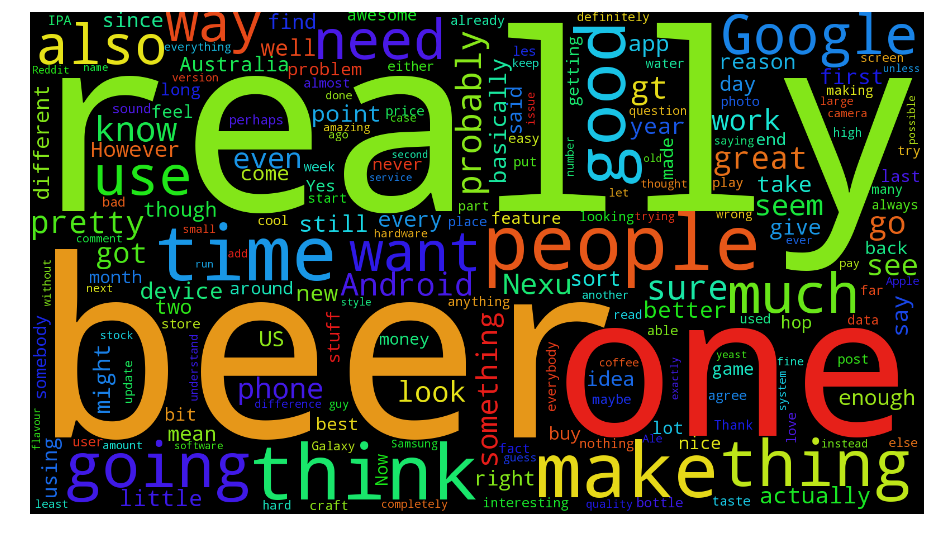

In [19]:
# Join all of the comments by spaces
text = " ".join(comment_frame['body'])
# Split them on the space into a list
word_list = text.split()
# Filter the list using nltk stopwords
filter_list = [word for word in word_list if word not in stopwords.words('english')]
# Join them again using spaces
filter_text = " ".join(filter_list)
# Generate the wordcloud
wordcloud = WordCloud(width=1600, height=900).generate(filter_text)
# Show the image
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")